# Random forest model

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [3]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Predictors. Load everything from relevant directory.

In [4]:
files = [path + "demand_predictors/" + i for i in os.listdir(path + "demand_predictors/")]

In [5]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [6]:
pred_ds.data_vars

Data variables:
    t2min     (region, time) float64 nan 289.1 289.3 290.0 ... 281.9 287.8 287.9
    t2m3      (region, time) float64 nan nan 293.0 293.7 ... 290.2 287.9 289.7
    msdwswrf  (region, time) float64 nan 293.4 257.6 298.1 ... 281.5 249.9 299.6
    cdd4      (region, time) float64 nan nan nan ... 0.221 0.221 -0.001519
    t2m       (region, time) float64 292.7 292.8 293.6 ... 287.1 289.8 292.2
    cdd3      (region, time) float64 nan nan 0.2243 ... -0.001518 -0.001519
    cdd       (region, time) float64 0.2843 0.1455 ... 5.631e-05 5.632e-05
    hdd4      (region, time) float64 nan nan nan 0.383 ... 2.467 2.565 2.572
    hdd       (region, time) float64 1.053 0.5182 0.3264 ... 4.067 1.35 0.06106
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    rh        (region, time) float64 92.39 91.39 91.05 ... 90.65 93.94 92.18
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2max     (region, time) float64 nan 297.4 2

### For a given region, get the data into a dataframe

In [7]:
def to_dataframe(target_da, predictors_ds, region):
    """
    Convert xarray data to pandas dataframe.
    """
    # Predictors to array
    predictors_arr = predictors_ds.sel(region=region, time=target_da["time"]).to_array("variable")
    # Data array of target and predictors
    da = xr.concat([
        predictors_arr,
        target_da.sel(region=region).expand_dims({"variable": ["demand"]})
    ], dim="variable")
    # Dataframe
    df = pd.DataFrame(
        da.transpose(),
        columns=da["variable"],
        index=target_da["time"]
    )
    return df

Set up a time column to either indicate:
1. day of week
2. weekend/weekday binary
3. winter/summer/transition
4. transition/(winter,summer) binary

In [8]:
def add_time_column(df, method):
    """
    Add a time column to df.
    
    df: dataframe to add to
    method: str indicating which method to use. Currently 'is_weekend'
    """
    if method == "is_weekend":
        # Bool for weekend day or weekday
        new_col = (df.index.weekday > 4).astype("int16")
    else:
        raise ValueError("Incorrect 'method'.")
    
    df[method] = new_col
    return df

In [9]:
region_dfs = {}
for region in dem_da.region.values:
    df = to_dataframe(dem_da, pred_ds, region)
    df = add_time_column(df, "is_weekend")
    new_cols = np.append(["demand", "is_weekend"], df.columns[:-2])
    df = df[new_cols]
    region_dfs[region] = df

In [10]:
region_dfs["NSW"].head()

,demand,is_weekend,t2min,t2m3,msdwswrf,cdd4,t2m,cdd3,cdd,hdd4,hdd,mtpr,rh,w10,t2max,hdd3,t2m4
2010-01-01,189098.854210,0,293.135916,295.652358,164.218843,0.230228,296.525003,0.236526,0.176162,0.173212,0.000324,0.000087,93.658535,3.132796,299.244528,0.173511,295.379525
2010-01-02,213642.465012,1,290.967947,295.889085,229.810077,0.199591,295.424110,0.179770,0.087857,0.174805,0.008797,0.000108,94.196278,2.557276,300.501642,0.173751,295.595364
2010-01-03,194617.495814,1,290.609908,294.763146,148.300158,0.134740,292.339987,0.136942,0.007749,0.220479,0.236494,0.000024,93.812825,2.931974,294.826772,0.236721,295.001880
2010-01-04,189128.506616,0,289.493653,293.841889,238.270861,0.115388,293.761230,0.046391,0.060270,0.223888,0.019122,0.000006,91.860632,2.919768,296.801895,0.241564,294.512735
2010-01-05,191152.737418,0,291.541431,294.200035,329.752634,0.115776,296.498553,0.124774,0.215896,0.223851,-0.000134,0.000003,91.115371,2.041179,300.815600,0.238905,294.506123


In [11]:
# NEM_df.describe()

# Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
def split(df, target_name, test_size, random_state):
    """
    Apply train_test_split to dataframe
    
    df: pandas dataframe
    target_name: column name of df to target
    test_size: float, proportion of data to test
    random_state: int
    """
    y = np.array(df[target_name]) # target
    X = np.array(df.drop(target_name, axis=1)) # predictors
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [14]:
predictors_list = df.drop("demand", axis=1).columns
print(predictors_list)

Index(['is_weekend', 't2min', 't2m3', 'msdwswrf', 'cdd4', 't2m', 'cdd3', 'cdd',
       'hdd4', 'hdd', 'mtpr', 'rh', 'w10', 't2max', 'hdd3', 't2m4'],
      dtype='object')


In [15]:
# # X: features/predictors
# # y: target/labels
# train_X, test_X, train_y, test_y = split(df, "demand", test_size=0.2, random_state=1)

In [16]:
# print('Training Features Shape:', train_X.shape)
# print('Training Labels Shape:', train_y.shape)
# print('Testing Features Shape:', test_X.shape)
# print('Testing Labels Shape:', test_y.shape)

Baseline forecast of training sample average

In [17]:
# # Unrealistically stupid baseline of training-period averaged demand
# ##(not accounting for season, day of week etc.)
# baseline_preds = np.mean(test_labels)

# # Baseline errors, and display average baseline error
# baseline_errors = abs(baseline_preds - test_labels)
# print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'MW')

# Train model and make predictions

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
def predict_forest(train_y, train_X, test_X, random_state, n_estimators=100, n_jobs=None):
    """
    Instantiate and fit a random forest model, return predictions.
    
    train_y: target for training set
    train_X: predictors for training set
    test_X: predictors for test set
    random_state: number for replication
    n_estimators: number of trees
    n_jobs: number of jobs to run in parallel
    """
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)
    rf.fit(train_X, train_y)
    return rf, rf.predict(test_X)

In [20]:
# %%time
# rf, predictions = predict_forest(train_y, train_X, test_X, random_state=666, n_estimators=100, n_jobs=5)

# Variable importance

In [21]:
# def variable_importance(rf, feature_list):
#     """
#     Return variable importances of random forest.
    
#     rf: RandomForestRegressor from sklearn
#     features_list: list of features/predictors
#     """
#     importances = list(rf.feature_importances_)
#     # importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
#     # return sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     # return pd.Series(importances, index=feature_list)
#     return importances

In [22]:
# importances = variable_importance(rf, predictors_list)

# Loop through all regions

In [25]:
importance_df = pd.DataFrame(columns=dem_da["region"].values, index=predictors_list)
for item in region_dfs.items():
    region = item[0]
    df = item[1]
    train_X, test_X, train_y, test_y = split(df, "demand", test_size=0.2, random_state=1)
    rf, predictions = predict_forest(
        train_y,
        train_X,
        test_X,
        random_state=666,
        n_estimators=100,
        n_jobs=5
    )
    importance_df[region] = rf.feature_importances_

In [26]:
importance_df.style.background_gradient(cmap='Blues')

,NSW,QLD,SA,TAS,VIC,NEM
is_weekend,0.066349,0.048905,0.045215,0.013197,0.099606,0.111474
t2min,0.044736,0.072358,0.052218,0.055596,0.051324,0.055495
t2m3,0.060198,0.191545,0.065513,0.127251,0.054247,0.049209
msdwswrf,0.067948,0.058611,0.081070,0.069244,0.072653,0.066950
cdd4,0.043952,0.059875,0.038165,0.053602,0.033365,0.043319
t2m,0.114313,0.078527,0.043706,0.041429,0.108205,0.114234
cdd3,0.050293,0.049390,0.040471,0.051266,0.036071,0.040681
cdd,0.068678,0.056575,0.062507,0.023113,0.071156,0.058041
hdd4,0.051743,0.047232,0.040280,0.053639,0.038003,0.044931
hdd,0.048923,0.047048,0.046712,0.049012,0.045615,0.068358


In [27]:
importance_df.mean(axis=1).sort_values(ascending=False)

t2max         0.125889
t2m3          0.091327
t2m           0.083402
msdwswrf      0.069413
hdd3          0.066132
is_weekend    0.064124
w10           0.059773
cdd           0.056678
rh            0.056121
t2min         0.055288
hdd           0.050945
hdd4          0.045971
cdd4          0.045380
cdd3          0.044695
t2m4          0.044280
mtpr          0.040580
dtype: float64

# Performance scores

In [125]:
import matplotlib.pyplot as plt

In [113]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

In [121]:
def get_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        scores.append(metric(y_true, y_pred))
    return scores

In [127]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [123]:
scores = get_scores(test_y, predictions, metrics)

In [131]:
# plt.bar(metric_names, scores)

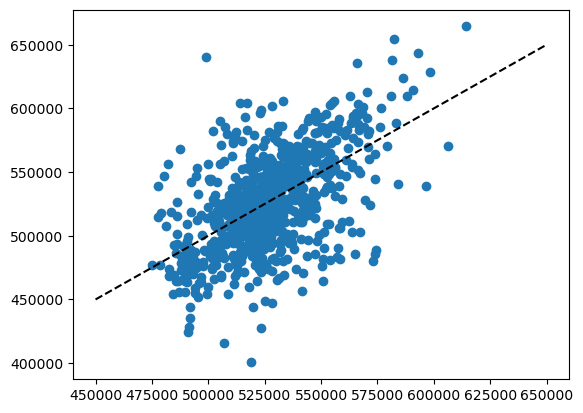

In [135]:
plt.scatter(predictions, test_y)
plt.plot(np.arange(4.5e5, 6.5e5, 100), np.arange(4.5e5, 6.5e5, 100), color="k", ls="--")